In [1]:
import numpy as np
import torch
import pandas as pd
import glob
import numpy as np
import pandas as pd
import yaml
import os
import math
import scipy.io as sio
from pathlib import Path

from plotting import *
from utils import *
from TMP_model import MP_model,TestTMPModel

In [ ]:
# Extract motion of videos for each subject and save all subfiles
#  in a folder same name of videos in the same directory of original video 

In [3]:
import scipy.io as sio
import os

# List of all subjects to process
all_subjects = [1,2,3,4,10,11,12,13,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,
            31,34,35,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51]

completed_subjects = [1,2,10,11,12,13,15,16,17,18,19,22, 20,21,23,24,25,26,27,28,29,30,31,32,33,34,35,36]
subjects = [37,38,39,40,41,42,43,44,45,46,47,48,49]

v3d_base_path = '../../../data/01_raw/F_Subjects/'
video_base_path = '../../../data/'

for subject_id in subjects:
    v3d_file = f'{v3d_base_path}F_v3d_Subject_{subject_id}.mat'
    video_file = f'{video_base_path}F_PG1_Subject_{subject_id}_L.avi'
    
    # Process the subject
    try:
        main_rub = sio.loadmat(v3d_file, squeeze_me=True, struct_as_record=False)
        single_videos(video_file, main_rub)
        print(f"Successfully processed Subject {subject_id}")
    except Exception as e:
        print(f"Error processing Subject {subject_id}: {e}")

Created output directory: ../../../data/F_PG1_Subject_37_L
Loaded existing motion mapping with 35 entries.
Available motions in this file:
  Added new motion: 'swinging_racket_rm' with ID 35
Saved motion mapping with 36 entries.
Video processing complete. All segments saved to ../../../data/F_PG1_Subject_37_L
Successfully processed Subject 37
Created output directory: ../../../data/F_PG1_Subject_38_L
Available motions in this file:
Saved motion mapping with 36 entries.
Video processing complete. All segments saved to ../../../data/F_PG1_Subject_38_L
Successfully processed Subject 38
Created output directory: ../../../data/F_PG1_Subject_39_L
Available motions in this file:
Saved motion mapping with 36 entries.
Video processing complete. All segments saved to ../../../data/F_PG1_Subject_39_L
Successfully processed Subject 39
Created output directory: ../../../data/F_PG1_Subject_40_L
Available motions in this file:
Saved motion mapping with 36 entries.
Video processing complete. All segme

#### Data Processing Workflow on server

1. Connect to VPN

2. Connect to remote server via SSH with port forwarding:
   ```bash
   ssh -p 38954 -L 8888:localhost:8888 arefeh@130.15.106.49
   ```
3. Activate virtual environment:
   ```bash
   source ~/myenv/bin/activate
   ```
4. Start Jupyter notebook on remote server:
   ```bash
   jupyter notebook --no-browser
   ```
5. In a new terminal session, transfer video folders one by one:
   ```bash
   scp -r -P 38954 F_PG1_Subject_49_L arefeh@130.15.106.49:/data1/users/arefeh/movementProject/MMpose/videos
   ```
6. Edit the main.py file on server to update subject IDs:
   ```bash
   # Path: movementProject/MMpose/main.py
   # Update the subject IDs as needed
   ```
7. Open a screen session:
   ```bash
   screen -r mysession
   ```
8. Run the main script:
   ```bash
   python main.py
   ```
9. Detach from screen session (to let it run in background):
   ```bash
   # Press Ctrl+A and then D
   ```
10. After processing completes, transfer results back to local machine:
    ```bash
    scp -r -P 38954 arefeh@130.15.106.49:/data1/users/arefeh/movementProject/MMpose/pred_out ./data/MMpose/pred_out
    ```

In this step, I gave those extracted motion videos to MMpose on the server
got 3d pose json files on server. 

Now I load separated motion vidoes json file, 
merge them in fixed order based on motion_mapping
and concatenate them in one datafrma for each subject

In [4]:

# Define settings and parameters
subjects = [27,28,29,30,31,32,33,34,35,36]
source_folder = '../../../data/MMpose/pred_out'
destination_folder = "../../../data/MMpose/df_files_3d"
merged_folder = "../../../data/MMpose/merged_csv_files"
visualization_folder = "../../../data/MMpose/visualizations"

# Load motion mapping
with open('../../../data/motion_mapping.json', 'r') as f:
    motion_mapping = json.load(f)['mapping']
    # Invert mapping for easier lookup
    id_to_motion = {str(v): k for k, v in motion_mapping.items()}

# Define equivalent motions - map to canonical ID
equivalent_motions = {
    # Format: ID: canonical_ID
    "20": "20",  # stretching -> stretching
    "31": "20",  # stretching_rm -> stretching
    "11": "11",  # cross_arms -> cross_arms
    "24": "11",  # crossarms -> cross_arms
    "12": "12",  # jumping_jacks -> jumping_jacks
    "23": "12",  # jumping_jack -> jumping_jacks
}

 
# subject_motions, common_motions = create_csv_from_json(
#     source_folder, destination_folder, subjects, equivalent_motions, id_to_motion
# )
    
# merge_subject_csv_files(destination_folder, merged_folder, subjects, common_motions)


In [5]:
motions_to_visualize = [2]
visualize_joint_trajectories(merged_folder, visualization_folder, motions_to_visualize, subjects, id_to_motion)


Visualizing motion 2: walking
  Visualizing joint: Hip
  Visualizing joint: RHip
  Visualizing joint: RKnee


In [ ]:
# Now we have 3d pose data csv files in same order motion videos for all subjects
# Visualize some frames in one sample csv file to verify 3d data

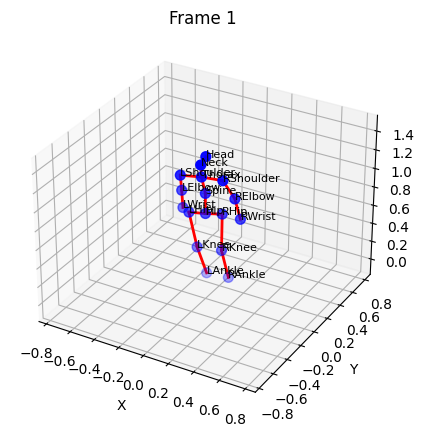

In [5]:
csv_file_path = "../../../data/MMpose/merged_csv_files/subject_32_all_motions.csv"  

if not os.path.exists(csv_file_path):
    print(f"Error: File not found at {csv_file_path}")
else:
    df_3d = pd.read_csv(csv_file_path)

first_frame_id = 1
fig = visualize_frame_3d(df_3d, first_frame_id)

# If you want to verify multiple frames, you could do:
# for frame_id in df_3d['frame_id'].unique()[2:7]:  # First 5 frames
#     visualize_frame_3d(df_3d, frame_id)

In [22]:
# Now we need to convert csv files(contain all motions) to bvh format so we can use for TMP model

In [2]:
source_folder =  "../../../data/MMpose/merged_csv_files"
destination_folder = "../../../data/MMpose/bvh_files"  

os.makedirs(destination_folder, exist_ok=True)

csv_files = glob.glob(os.path.join(source_folder, "*.csv"))

for file_path in csv_files:
    print(f"Processing file: {file_path}")
    
    with open(file_path, 'r') as f:
        df_3d = pd.read_csv(f)

    filename = os.path.basename(file_path)
    filename_without_ext = os.path.splitext(filename)[0]
    output_bvh_path = os.path.join(destination_folder, f"{filename_without_ext}.bvh")
    create_h36m_bvh(df_3d, output_bvh_path, fps=120)

Processing file: ../../../data/MMpose/merged_csv_files/subject_17_all_motions.csv
BVH file created at ../../../data/MMpose/bvh_files/subject_17_all_motions.bvh
Processing file: ../../../data/MMpose/merged_csv_files/subject_31_all_motions.csv
BVH file created at ../../../data/MMpose/bvh_files/subject_31_all_motions.bvh
Processing file: ../../../data/MMpose/merged_csv_files/subject_46_all_motions.csv
BVH file created at ../../../data/MMpose/bvh_files/subject_46_all_motions.bvh
Processing file: ../../../data/MMpose/merged_csv_files/subject_23_all_motions.csv
BVH file created at ../../../data/MMpose/bvh_files/subject_23_all_motions.bvh
Processing file: ../../../data/MMpose/merged_csv_files/subject_34_all_motions.csv
BVH file created at ../../../data/MMpose/bvh_files/subject_34_all_motions.bvh
Processing file: ../../../data/MMpose/merged_csv_files/subject_22_all_motions.csv
BVH file created at ../../../data/MMpose/bvh_files/subject_22_all_motions.bvh
Processing file: ../../../data/MMpose/me

In [52]:


def convert_motion_id_to_bvh(motion_id, id_to_motion=None,
                             source_folder = None,destination_folder = None, csv_pattern =None):
    if source_folder == None:
        source_folder = "../../../data/MMpose/df_files_3d"
    
    # Create a specific destination folder for this motion
    motion_name = id_to_motion.get(str(motion_id), f"motion_{motion_id}") if id_to_motion else f"motion_{motion_id}"
    if destination_folder == None:
        destination_folder = f"../../../data/MMpose/bvh_files/bvh_files_motion_{motion_id}_{motion_name}"
    
    os.makedirs(destination_folder, exist_ok=True)
    
    padded_motion_id = str(motion_id).zfill(2)
    
    if csv_pattern == None:
        csv_pattern = f"subject_*_motion_{padded_motion_id}.csv"
    csv_files = glob.glob(os.path.join(source_folder, csv_pattern))
    
    print(f"Processing motion ID: {motion_id} ({motion_name})")
    print(f"Found {len(csv_files)} CSV files for this motion")
    
    for file_path in csv_files:
        
        df_3d = pd.read_csv(file_path)
        filename = os.path.basename(file_path)
        filename_without_ext = os.path.splitext(filename)[0]
        output_bvh_path = os.path.join(destination_folder, f"{filename_without_ext}.bvh")
        
        create_h36m_bvh(df_3d, output_bvh_path, fps=120)
    
    print(f"Conversion complete for motion {motion_id} ({motion_name})")


In [ ]:
# get motion capture data for specific motion (motion id 0 to 5)
with open('../../../data/motion_mapping.json', 'r') as f:
    motion_mapping = json.load(f)['mapping']
    # Invert mapping for easier lookup
    id_to_motion = {str(v): k for k, v in motion_mapping.items()}

for i in range(5):

# Convert a specific motion ID to BVH
    motion_id = i # Example: 2: walking
    motion_name = id_to_motion.get(str(motion_id), f"unknown_motion_{motion_id}")
    print(motion_name)
   
    convert_motion_id_to_bvh(motion_id, id_to_motion=id_to_motion)

    

##### Segmentation step to segment one specific movement for one subject based on paper

In [ ]:
#lets start with walking (motion_id = 2) and subject 27
import pandas as pd
import numpy as np
import os
import json
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import pickle

# Load your data
motion_id = 2
subject_id = 27
padded_motion_id = str(motion_id).zfill(2)

csv_file = f"../../../data/MMpose/df_files_3d/subject_{subject_id}_motion_{padded_motion_id}.csv"

with open('../../../data/motion_mapping.json', 'r') as f:
    motion_mapping = json.load(f)['mapping']
    id_to_motion = {str(v): k for k, v in motion_mapping.items()}  

motion_name = id_to_motion.get(str(motion_id), f"motion_{motion_id}") if id_to_motion else f"motion_{motion_id}"
   
destination_folder = f"../../../data/MMpose/segmented_files/subject_{subject_id}_motion_{motion_id}_{motion_name}"
    
os.makedirs(destination_folder, exist_ok=True)
    
df_3d = pd.read_csv(csv_file)


frames = df_3d['frame_id'].unique()
fps = 120  # Given in your description

# Step 1: Extract wrist and foot markers positions per frame
# We need to reshape the data to get positions for each joint at each frame

# Get positions for relevant joints (LWrist, RWrist, LAnkle, RAnkle)
joint_positions = {}
for frame in frames:
    frame_data = df_3d[df_3d['frame_id'] == frame]
    
    # Initialize positions for this frame
    joint_positions[frame] = {}
    
    # Extract positions for each joint we need
    for joint in ['LWrist', 'RWrist', 'LAnkle', 'RAnkle']:
        joint_data = frame_data[frame_data['joint_name'] == joint]
        if len(joint_data) > 0:
            # Get x, y, z coordinates
            joint_positions[frame][joint] = np.array([
                joint_data['x_3d'].values[0],
                joint_data['y_3d'].values[0],
                joint_data['z_3d'].values[0]
            ])
        else:
            # Use zeros if joint data is missing
            joint_positions[frame][joint] = np.zeros(3)

# Convert to numpy arrays for easier processing
sorted_frames = sorted(frames)
lwrist_pos = np.array([joint_positions[frame]['LWrist'] for frame in sorted_frames])
rwrist_pos = np.array([joint_positions[frame]['RWrist'] for frame in sorted_frames])
lankle_pos = np.array([joint_positions[frame]['LAnkle'] for frame in sorted_frames])
rankle_pos = np.array([joint_positions[frame]['RAnkle'] for frame in sorted_frames])

# Step 2: Calculate velocities (difference between consecutive frames)
def calculate_velocity(positions):
    # Calculate difference between consecutive positions
    velocities = np.diff(positions, axis=0)
    # Pad with a zero at the beginning to maintain array length
    velocities = np.vstack([np.zeros((1, 3)), velocities])
    return velocities

lwrist_vel = calculate_velocity(lwrist_pos)
rwrist_vel = calculate_velocity(rwrist_pos)
lankle_vel = calculate_velocity(lankle_pos)
rankle_vel = calculate_velocity(rankle_pos)

# Step 3: Calculate speeds (magnitude of velocity)
def calculate_speed(velocity):
    return np.sqrt(np.sum(velocity**2, axis=1))

lwrist_speed = calculate_speed(lwrist_vel)
rwrist_speed = calculate_speed(rwrist_vel)
lankle_speed = calculate_speed(lankle_vel)
rankle_speed = calculate_speed(rankle_vel)

# Step 4: Sum the speeds of all markers
summed_speed = lwrist_speed + rwrist_speed + lankle_speed + rankle_speed

# Step 5: Find local minima in the summed speed
# Minimum distance between boundaries: 160ms = 0.16s * 120fps = 19.2 frames ≈ 19 frames
min_distance = int(0.16 * fps)  # 160ms converted to frames at 120fps

# Find local minima (as peaks in negative speed)
negative_speed = -summed_speed
minima_indices, _ = find_peaks(negative_speed, distance=min_distance)

# Add the first and last frame as boundaries
segment_boundaries = np.concatenate([[0], minima_indices, [len(summed_speed)-1]])

# Step 6: Visualize the segmentation
plt.figure(figsize=(15, 6))
plt.plot(summed_speed, label='Summed Speed')
plt.plot(minima_indices, summed_speed[minima_indices], 'ro', label='Detected Minima')
plt.vlines(segment_boundaries, ymin=0, ymax=max(summed_speed), colors='g', linestyles='dashed', label='Segment Boundaries')
plt.legend()
plt.title(f'Movement Segmentation for {motion_name}')
plt.xlabel('Frame')
plt.ylabel('Summed Speed')
plt.savefig(os.path.join(destination_folder, 'segmentation.png'))
plt.close()

# Step 7: Create segments based on boundaries
segments = []
for i in range(len(segment_boundaries)-1):
    start_idx = int(segment_boundaries[i])
    end_idx = int(segment_boundaries[i+1])
    
    # Get the actual frame IDs for this segment
    start_frame = sorted_frames[start_idx]
    end_frame = sorted_frames[end_idx]
    
    # Extract the segment data for all joints
    segment_data = df_3d[(df_3d['frame_id'] >= start_frame) & (df_3d['frame_id'] <= end_frame)].copy()
    segments.append(segment_data)
    
    # Optionally save each segment to a separate CSV
    csv_pattern = f"sub_{subject_id}_motion_{motion_id}_seg_{i+1}.csv"
    segment_data.to_csv(os.path.join(destination_folder, csv_pattern), index=False)
    

print(f"Segmentation complete. Found {len(segments)} segments.")
print(f"Segment frames: {[(segments[i]['frame_id'].min(), segments[i]['frame_id'].max()) for i in range(len(segments))]}")


Segmentation complete. Found 13 segments.
Segment frames: [(0, 3), (3, 24), (24, 43), (43, 65), (65, 87), (87, 109), (109, 140), (140, 178), (178, 213), (213, 241), (241, 261), (261, 288), (288, 296)]
Created 13 processed segments for TMP model.
Each segment has shape [num_signals=51, segment_length=varies]


In [54]:
source_folder = "../../../data/MMpose/segmented_files/subject_27_motion_2_walking"
dest_folder = "../../../data/MMpose/segmented_files/subject_27_motion_2_walking/bvh_files"
csv_pattern = "*.csv"
convert_motion_id_to_bvh(motion_id, id_to_motion=id_to_motion,
                         source_folder = source_folder,destination_folder = dest_folder, csv_pattern =csv_pattern)

Processing motion ID: 2 (walking)
Found 13 CSV files for this motion
BVH file created at ../../../data/MMpose/segmented_files/subject_27_motion_2_walking/bvh_files/segment_11.bvh
BVH file created at ../../../data/MMpose/segmented_files/subject_27_motion_2_walking/bvh_files/segment_7.bvh
BVH file created at ../../../data/MMpose/segmented_files/subject_27_motion_2_walking/bvh_files/segment_13.bvh
BVH file created at ../../../data/MMpose/segmented_files/subject_27_motion_2_walking/bvh_files/segment_12.bvh
BVH file created at ../../../data/MMpose/segmented_files/subject_27_motion_2_walking/bvh_files/segment_5.bvh
BVH file created at ../../../data/MMpose/segmented_files/subject_27_motion_2_walking/bvh_files/segment_2.bvh
BVH file created at ../../../data/MMpose/segmented_files/subject_27_motion_2_walking/bvh_files/segment_10.bvh
BVH file created at ../../../data/MMpose/segmented_files/subject_27_motion_2_walking/bvh_files/segment_6.bvh
BVH file created at ../../../data/MMpose/segmented_file

In [48]:
# Add this after finding the segment boundaries and before creating segments
# Create a plot showing the first 5 joint trajectories with segment boundaries

plt.figure(figsize=(15, 10))

# Select 5 joints to display
display_joints = ['LWrist', 'RWrist', 'LAnkle', 'RAnkle', 'Hip']
coords = ['x_3d', 'y_3d', 'z_3d']
colors = ['r', 'g', 'b']

# Create subplots for each joint
for j_idx, joint in enumerate(display_joints):
    plt.subplot(len(display_joints), 1, j_idx+1)
    
    # Get data for this joint
    joint_data = df_3d[df_3d['joint_name'] == joint]
    
    # Sort by frame
    joint_data = joint_data.sort_values('frame_id')
    
    # Plot each coordinate (x, y, z)
    for c_idx, coord in enumerate(coords):
        plt.plot(joint_data['frame_id'], joint_data[coord], 
                 color=colors[c_idx], label=f'{coord}', alpha=0.7)
    
    # Add segment boundary lines
    boundary_frames = [sorted_frames[idx] for idx in segment_boundaries]
    for b_frame in boundary_frames:
        plt.axvline(x=b_frame, color='k', linestyle='--', alpha=0.5)
    
    # Set title and labels
    plt.title(f'{joint} Trajectory')
    plt.ylabel('Position')
    
    # Only add legend to the first subplot to avoid redundancy
    if j_idx == 0:
        plt.legend()

# Set xlabel only for the bottom subplot
plt.xlabel('Frame')

plt.tight_layout()
plt.savefig(os.path.join(destination_folder, 'joint_trajectories_with_boundaries.png'))
plt.close()

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import re
from scipy.spatial.transform import Rotation


fps = 120  # Your data is at 120 fps

# Function to extract joint angles from BVH
def extract_angles_from_bvh(bvh_file_path):
    """Extract joint rotation angles from a BVH file"""
    with open(bvh_file_path, 'r') as f:
        content = f.read()
    
    # Find the motion section
    motion_match = re.search(r'MOTION\s+Frames:\s+(\d+)\s+Frame Time:\s+([\d\.]+)(.*)', content, re.DOTALL)
    if not motion_match:
        return None
    
    frames = int(motion_match.group(1))
    frame_time = float(motion_match.group(2))  # This is the time per frame in seconds
    motion_data = motion_match.group(3).strip().split('\n')
    
    # Find channels to understand the structure
    channels = {}
    joint_order = []
    
    hierarchy_match = re.search(r'HIERARCHY(.*?)MOTION', content, re.DOTALL)
    if hierarchy_match:
        hierarchy = hierarchy_match.group(1)
        # Extract ROOT and JOINT definitions
        joint_defs = re.findall(r'(ROOT|JOINT)\s+(\w+).*?CHANNELS\s+(\d+)\s+(.*?)(?=JOINT|\}|End Site)', 
                                hierarchy, re.DOTALL)
        
        channel_idx = 0
        for joint_type, joint_name, num_channels, channel_def in joint_defs:
            num = int(num_channels)
            channel_types = channel_def.strip().split()
            
            rotation_indices = []
            for i, channel in enumerate(channel_types):
                if 'rotation' in channel:
                    rotation_indices.append(i)
            
            channels[joint_name] = {
                'start_idx': channel_idx,
                'rotation_indices': rotation_indices,
                'rotation_types': [channel_types[i] for i in rotation_indices]
            }
            
            joint_order.append(joint_name)
            channel_idx += num
    
    # Parse motion data
    motion_values = [list(map(float, line.split())) for line in motion_data]
    
    # Extract rotation data for each joint
    joint_rotations = {}
    
    for joint_name, channel_info in channels.items():
        start_idx = channel_info['start_idx']
        rot_indices = channel_info['rotation_indices']
        
        # Initialize rotation arrays for this joint
        rotations = np.zeros((frames, len(rot_indices)))
        
        # Extract rotations for each frame
        for frame_idx, frame_data in enumerate(motion_values):
            for i, rot_idx in enumerate(rot_indices):
                rotations[frame_idx, i] = frame_data[start_idx + rot_idx]
        
        joint_rotations[joint_name] = {
            'values': rotations,
            'types': channel_info['rotation_types']
        }
    
    return joint_rotations, joint_order, frame_time

# Load joint angles from BVH
bvh_file = f"../../../data/MMpose/bvh_files/bvh_files_motion_{motion_id}_{motion_name}/subject_{subject_id}_motion_{padded_motion_id}.bvh"
joint_rotations, joint_order, frame_time = extract_angles_from_bvh(bvh_file)
if joint_rotations:
    # Select joints to display
    joints_to_display = ['LWrist', 'RWrist', 'LAnkle', 'RAnkle', 'Hip']
    # Filter to available joints
    joints_to_display = [j for j in joints_to_display if j in joint_rotations]
    
    # If no specified joints are found, use the first 5 available joints
    if not joints_to_display and joint_order:
        joints_to_display = joint_order[:5]
    
    # Create time array (in seconds)
    num_frames = joint_rotations[joint_order[0]]['values'].shape[0]
    time_array = np.arange(num_frames) * frame_time  # Convert frames to seconds
    
    # Convert segment boundaries from frames to time
    time_boundaries = [boundary * frame_time for boundary in segment_boundaries]
    
    # Create figure for joint angles
    plt.figure(figsize=(15, 10))
    
    for j_idx, joint_name in enumerate(joints_to_display):
        plt.subplot(len(joints_to_display), 1, j_idx+1)
        
        # Get rotation data for this joint
        rotation_data = joint_rotations[joint_name]['values']
        rotation_types = joint_rotations[joint_name]['types']
        
        # Plot each rotation component vs time
        for r_idx, r_type in enumerate(rotation_types):
            plt.plot(time_array, rotation_data[:, r_idx], label=r_type, alpha=0.7)
        
        # Add segment boundary lines at corresponding time points
        for b_time in time_boundaries:
            plt.axvline(x=b_time, color='k', linestyle='--', alpha=0.5)
        
        plt.title(f'{joint_name} Joint Angles')
        plt.ylabel('Angle (degrees)')
        
        if j_idx == 0:
            plt.legend()
    
    plt.xlabel('Time (seconds)')
    plt.tight_layout()
    plt.savefig(os.path.join(destination_folder, 'bvh_joint_angles_with_boundaries_time.png'))
    plt.close()
    
    # Also update the speed plot to use time
    plt.figure(figsize=(15, 6))
    plt.plot(time_array, summed_speed, label='Summed Speed')
    plt.plot([time_array[i] for i in minima_indices], 
             summed_speed[minima_indices], 'ro', label='Detected Minima')
    plt.vlines(time_boundaries, ymin=0, ymax=max(summed_speed), 
               colors='g', linestyles='dashed', label='Segment Boundaries')
    plt.legend()
    plt.title(f'Movement Segmentation for {motion_name}')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Summed Speed')
    plt.savefig(os.path.join(destination_folder, 'segmentation_time.png'))
    plt.close()
    
    print(f"Joint angle visualization saved with time on x-axis")
else:
    print("Failed to extract joint angles from BVH file")

Joint angle visualization saved with time on x-axis


In [43]:
[t*1000 for t in time_boundaries]

[0.0,
 33.333333333333336,
 225.0,
 516.6666666666666,
 683.3333333333334,
 983.3333333333333,
 1158.3333333333333,
 1375.0,
 1533.3333333333333,
 1708.3333333333333,
 1891.6666666666665,
 1916.6666666666667]

Model Training

In [3]:

destination_folder = f"../../../data/MMpose/bvh_files/bvh_files_motion_{motion_id}_{motion_name}"
folder_path = "../../../data/MMpose/bvh_files" 
# folder_path = destination_folder  # if specific motion is assumed for trainng only
    # Read BVH files
bvh_data = read_bvh_files(folder_path)
if not bvh_data:
    raise ValueError("No BVH files could be read")

# Process data according to paper specifications
processed_data2 = process_bvh_data(bvh_data)
# a = [torch.tensor(d) for d in processed_data2]
num_segments = len(processed_data2)


# based on TMP code: the format of data=list(segment_data[signals,time]) --> signals are fixed but time 
# could vary in segments
# as far as i underastand:
# num segments = number of videos we have (each subject)
# num_signals =  number of sensors/signals. = number of features / joint infor in data = 54 here
print(f'num of segments : {num_segments}')
num_signals = processed_data2[0].shape[0]
print(f'num of signal : {num_signals}')


Processed segment shape: (54, 368)
Processed segment shape: (54, 301)
Processed segment shape: (54, 290)
Processed segment shape: (54, 236)
Processed segment shape: (54, 408)
Processed segment shape: (54, 228)
Processed segment shape: (54, 378)
Processed segment shape: (54, 334)
Processed segment shape: (54, 501)
Processed segment shape: (54, 284)
Processed segment shape: (54, 373)
Processed segment shape: (54, 530)
Processed segment shape: (54, 367)
Processed segment shape: (54, 412)
Processed segment shape: (54, 330)
Processed segment shape: (54, 278)
Processed segment shape: (54, 293)
Processed segment shape: (54, 407)
num of segments : 18
num of signal : 54
